# Anime Recommendation System Using Content-Based Filtering and K-Nearest Neighbor

## Project Description
### Background Description of the Anime Recommendation System Using Content-Based Filtering and K-Nearest Neighbor
This project aims to develop a recommendation system that can suggest top-N anime titles to users based on their preferences using content-based filtering and the K-Nearest Neighbor (KNN) algorithm. Currently, many recommendation systems rely on collaborative filtering, which can suffer from cold-start problems and data sparsity. By implementing content-based filtering, the system can provide personalized recommendations even with limited user interaction data, enhancing user experience and engagement.

## Data Collection

Import Libraries

In [1]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

Kaggle configuration

In [2]:
!pip install -q kaggle

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bachtiarashidiqy","key":"2d4d607e9e8c157c96f1054508c35756"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

[Anime Dataset 2023](https://www.kaggle.com/datasets/dbdmobile/myanimelist-dataset/data?select=anime-filtered.csv)

Download datasets from kaggle

In [5]:
!kaggle datasets download -d dbdmobile/myanimelist-dataset

Dataset URL: https://www.kaggle.com/datasets/dbdmobile/myanimelist-dataset
License(s): DbCL-1.0
 99% 1.77G/1.80G [00:18<00:00, 122MB/s]
100% 1.80G/1.80G [00:18<00:00, 102MB/s]


Extract zip

In [6]:
!unzip /content/myanimelist-dataset.zip

Archive:  /content/myanimelist-dataset.zip
  inflating: anime-dataset-2023.csv  
  inflating: anime-filtered.csv      
  inflating: final_animedataset.csv  
  inflating: user-filtered.csv       
  inflating: users-details-2023.csv  
  inflating: users-score-2023.csv    


We can see that after we extract the zip file, there are many csv files, but in this case we only use the `anime-filtered.csv` file.

Read anime-filtered.csv

In [7]:
df = pd.read_csv('/content/anime-filtered.csv')

## Data Understanding

In [8]:
df.head()

,anime_id,Name,Score,Genres,English name,Japanese name,sypnopsis,Type,Episodes,Aired,...,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,"In the year 2071, humanity has colonized sever...",TV,26,"Apr 3, 1998 to Apr 24, 1999",...,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,"other day, another bounty—such is the life of ...",Movie,1,"Sep 1, 2001",...,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,"Vash the Stampede is the man with a $$60,000,0...",TV,26,"Apr 1, 1998 to Sep 30, 1998",...,24 min. per ep.,PG-13 - Teens 13 or older,266.0,201,558913,12944,29113,343492,25465,13925
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),ches are individuals with special powers like ...,TV,26,"Jul 2, 2002 to Dec 24, 2002",...,25 min. per ep.,PG-13 - Teens 13 or older,2481.0,1467,94683,587,4300,46165,5121,5378
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,It is the dark century and the people are suff...,TV,52,"Sep 30, 2004 to Sep 29, 2005",...,23 min. per ep.,PG - Children,3710.0,4369,13224,18,642,7314,766,1108


In [9]:
print(f'This dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

This dataset has 14952 rows and 25 columns.


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14952 entries, 0 to 14951
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   anime_id       14952 non-null  int64  
 1   Name           14952 non-null  object 
 2   Score          14952 non-null  float64
 3   Genres         14952 non-null  object 
 4   English name   14952 non-null  object 
 5   Japanese name  14952 non-null  object 
 6   sypnopsis      13602 non-null  object 
 7   Type           14952 non-null  object 
 8   Episodes       14952 non-null  object 
 9   Aired          14952 non-null  object 
 10  Premiered      14952 non-null  object 
 11  Producers      14952 non-null  object 
 12  Licensors      14952 non-null  object 
 13  Studios        14952 non-null  object 
 14  Source         14952 non-null  object 
 15  Duration       14952 non-null  object 
 16  Rating         14952 non-null  object 
 17  Ranked         13231 non-null  float64
 18  Popula

Based on the provided output, the following conclusions can be drawn:

There are a total of 25 columns in the dataframe.

* Out of these, 15 columns are of data type object, which are most likely categorical features. These columns are: Name, Genres, English Name, Japanese Name, Synopsis, Type, Episodes, Aired, Premiered, Producers, Licensors, Studios, Source, Duration, and Rating.

* Additionally, there are 2 columns with data type float64, which are likely numerical features. These columns are: Score and Ranked.

* The remaining 8 columns are of data type int64, which may also serve as numerical features. These columns include: anime_id, Popularity, Members, Favorites, Watching, Completed, On-Hold, and Dropped.

Check for duplicate data

In [11]:
df.duplicated().sum()

np.int64(0)

There is no duplicate data

## Exploratory Data Analysis

### Variabel Description

In [12]:
df.columns

Index(['anime_id', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'sypnopsis', 'Type', 'Episodes', 'Aired', 'Premiered', 'Producers',
       'Licensors', 'Studios', 'Source', 'Duration', 'Rating', 'Ranked',
       'Popularity', 'Members', 'Favorites', 'Watching', 'Completed',
       'On-Hold', 'Dropped'],
      dtype='object')

**Data information**

The dataset's columns contain the following information:

* anime_id: Unique ID for each anime (number or identification code).
* Name: The original title of the anime.
* Score: The rating or score assigned to the anime.
* Genres: The genres of the anime, separated by commas (e.g., Action, Comedy, Fantasy).
* English Name: The English title of the anime (if available).
* Japanese Name: The Japanese title of the anime (if available).
* Synopsis: A brief description or plot summary of the anime.
* Type: The type of anime (e.g., TV Series, Movie, OVA, etc.).
* Episodes: The number of episodes in the anime.
* Aired: The original airing date of the anime.
* Premiered: The season and year of the anime's debut.
* Producers: The production companies or producers of the anime.
* Licensors: The license holders of the anime (e.g., streaming platforms).
* Studios: The animation studios involved.
* Source: The source material of the anime (e.g., manga, light novel, original).
* Duration: Duration of each episode.
* Rating: Age rating for viewers.
* Ranked: The ranking of the anime based on popularity or other criteria.
* Popularity: The popularity rank of the anime.
* Members: The number of members who added the anime to their lists on the platform.
* Favorites: The number of users who marked the anime as favorite.
* Watching: The number of users currently watching the anime.
* Completed: The number of users who have finished watching.
* On Hold: The number of users who paused watching.
* Dropped: The number of users who discontinued watching.

### Visualizations

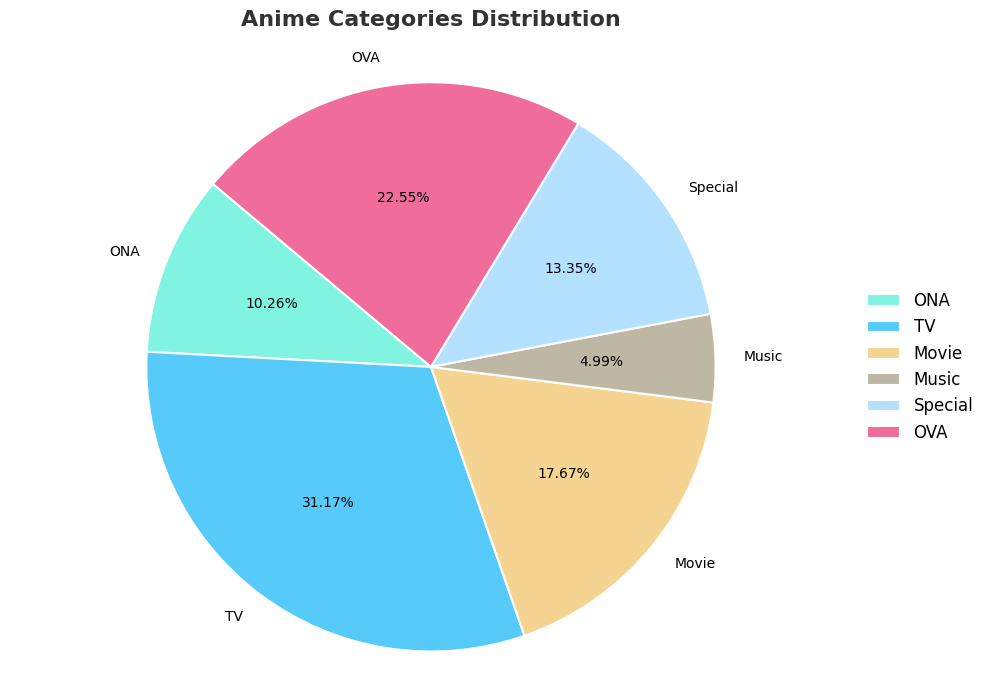

In [13]:
import matplotlib.pyplot as plt

# Count the number of entries for each type
ona_count = df.loc[df['Type'] == 'ONA'].shape[0]
tv_count = df.loc[df['Type'] == 'TV'].shape[0]
movie_count = df.loc[df['Type'] == 'Movie'].shape[0]
music_count = df.loc[df['Type'] == 'Music'].shape[0]
special_count = df.loc[df['Type'] == 'Special'].shape[0]
ova_count = df.loc[df['Type'] == 'OVA'].shape[0]

# Labels and corresponding colors
labels = ['ONA', 'TV', 'Movie', 'Music', 'Special', 'OVA']
colors = ['#81F4E1', '#56CBF9', '#F5D491', '#BEB7A4', '#B4E1FF', '#F06C9B']

# Plotting
plt.figure(figsize=(10, 7))
plt.title('Anime Categories Distribution', fontsize=16, fontweight='bold', color='#333333', pad=20)

# Create pie chart with enhanced aesthetics
plt.pie(
    [ona_count, tv_count, movie_count, music_count, special_count, ova_count],
    labels=labels,
    colors=colors,
    autopct=lambda p: '{:.2f}%'.format(p) if p > 0 else '',  # Show two decimal places
    startangle=140,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
)

# Add a legend outside the pie to avoid overlapping with title
plt.legend(
    labels,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    fontsize=12,
    frameon=False
)

plt.axis('equal')
plt.tight_layout()
plt.show()

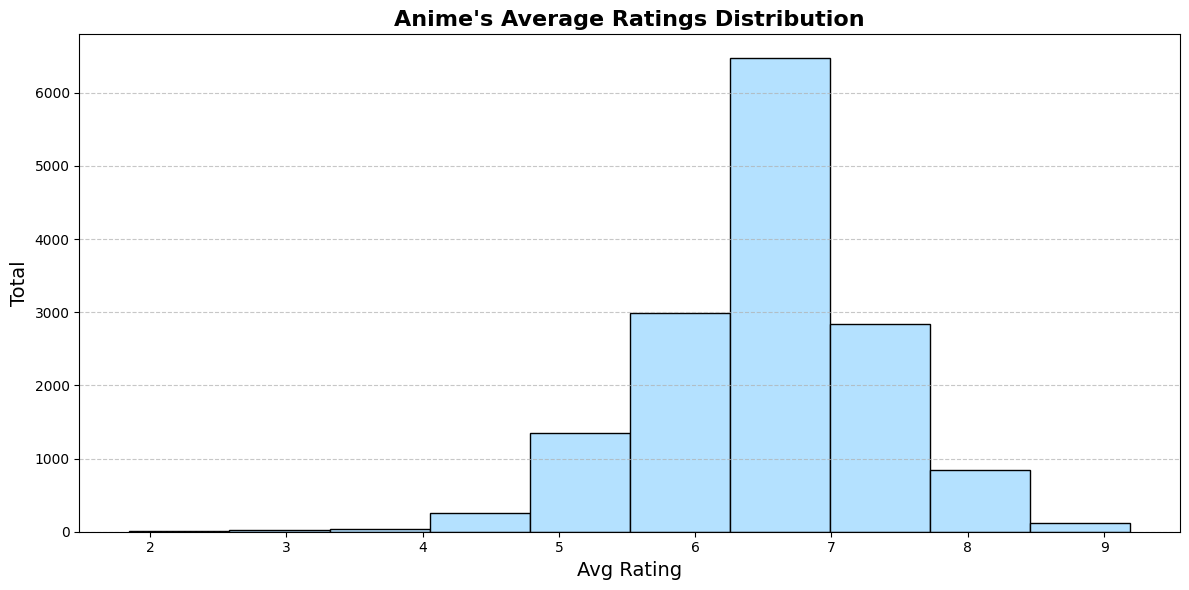

In [14]:
# Histogram Rating
plt.figure(figsize=(12, 6))
plt.hist(df['Score'], color='#B4E1FF', edgecolor='black')
plt.ylabel('Total', fontsize=14)
plt.xlabel('Avg Rating', fontsize=14)
plt.title("Anime's Average Ratings Distribution", fontsize=16, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
anime_id,14952.0,19017.432718,14588.758618,1.00,4602.50,16729.00,33513.25,48492.00
Score,14952.0,6.511526,0.807185,1.85,6.08,6.51,7.01,9.19
Ranked,13231.0,6829.853828,4168.929475,1.00,3309.50,6618.00,9942.00,15780.00
Popularity,14952.0,7465.970907,4313.169381,1.00,3732.00,7466.50,11194.00,17565.00
Members,14952.0,40686.475321,134874.350809,200.00,736.00,3493.50,19193.25,2589552.00
Favorites,14952.0,537.629882,4399.016449,0.00,1.00,6.00,47.00,183914.00
Watching,14952.0,2619.806715,15190.098642,0.00,27.00,127.00,723.00,887333.00
Completed,14952.0,25943.096977,98127.291289,0.00,246.00,1515.50,9797.00,2182587.00
On-Hold,14952.0,1121.307986,4613.759597,0.00,14.00,78.00,388.25,187919.00
Dropped,14952.0,1377.861891,5110.874501,0.00,48.00,102.00,377.00,174710.00


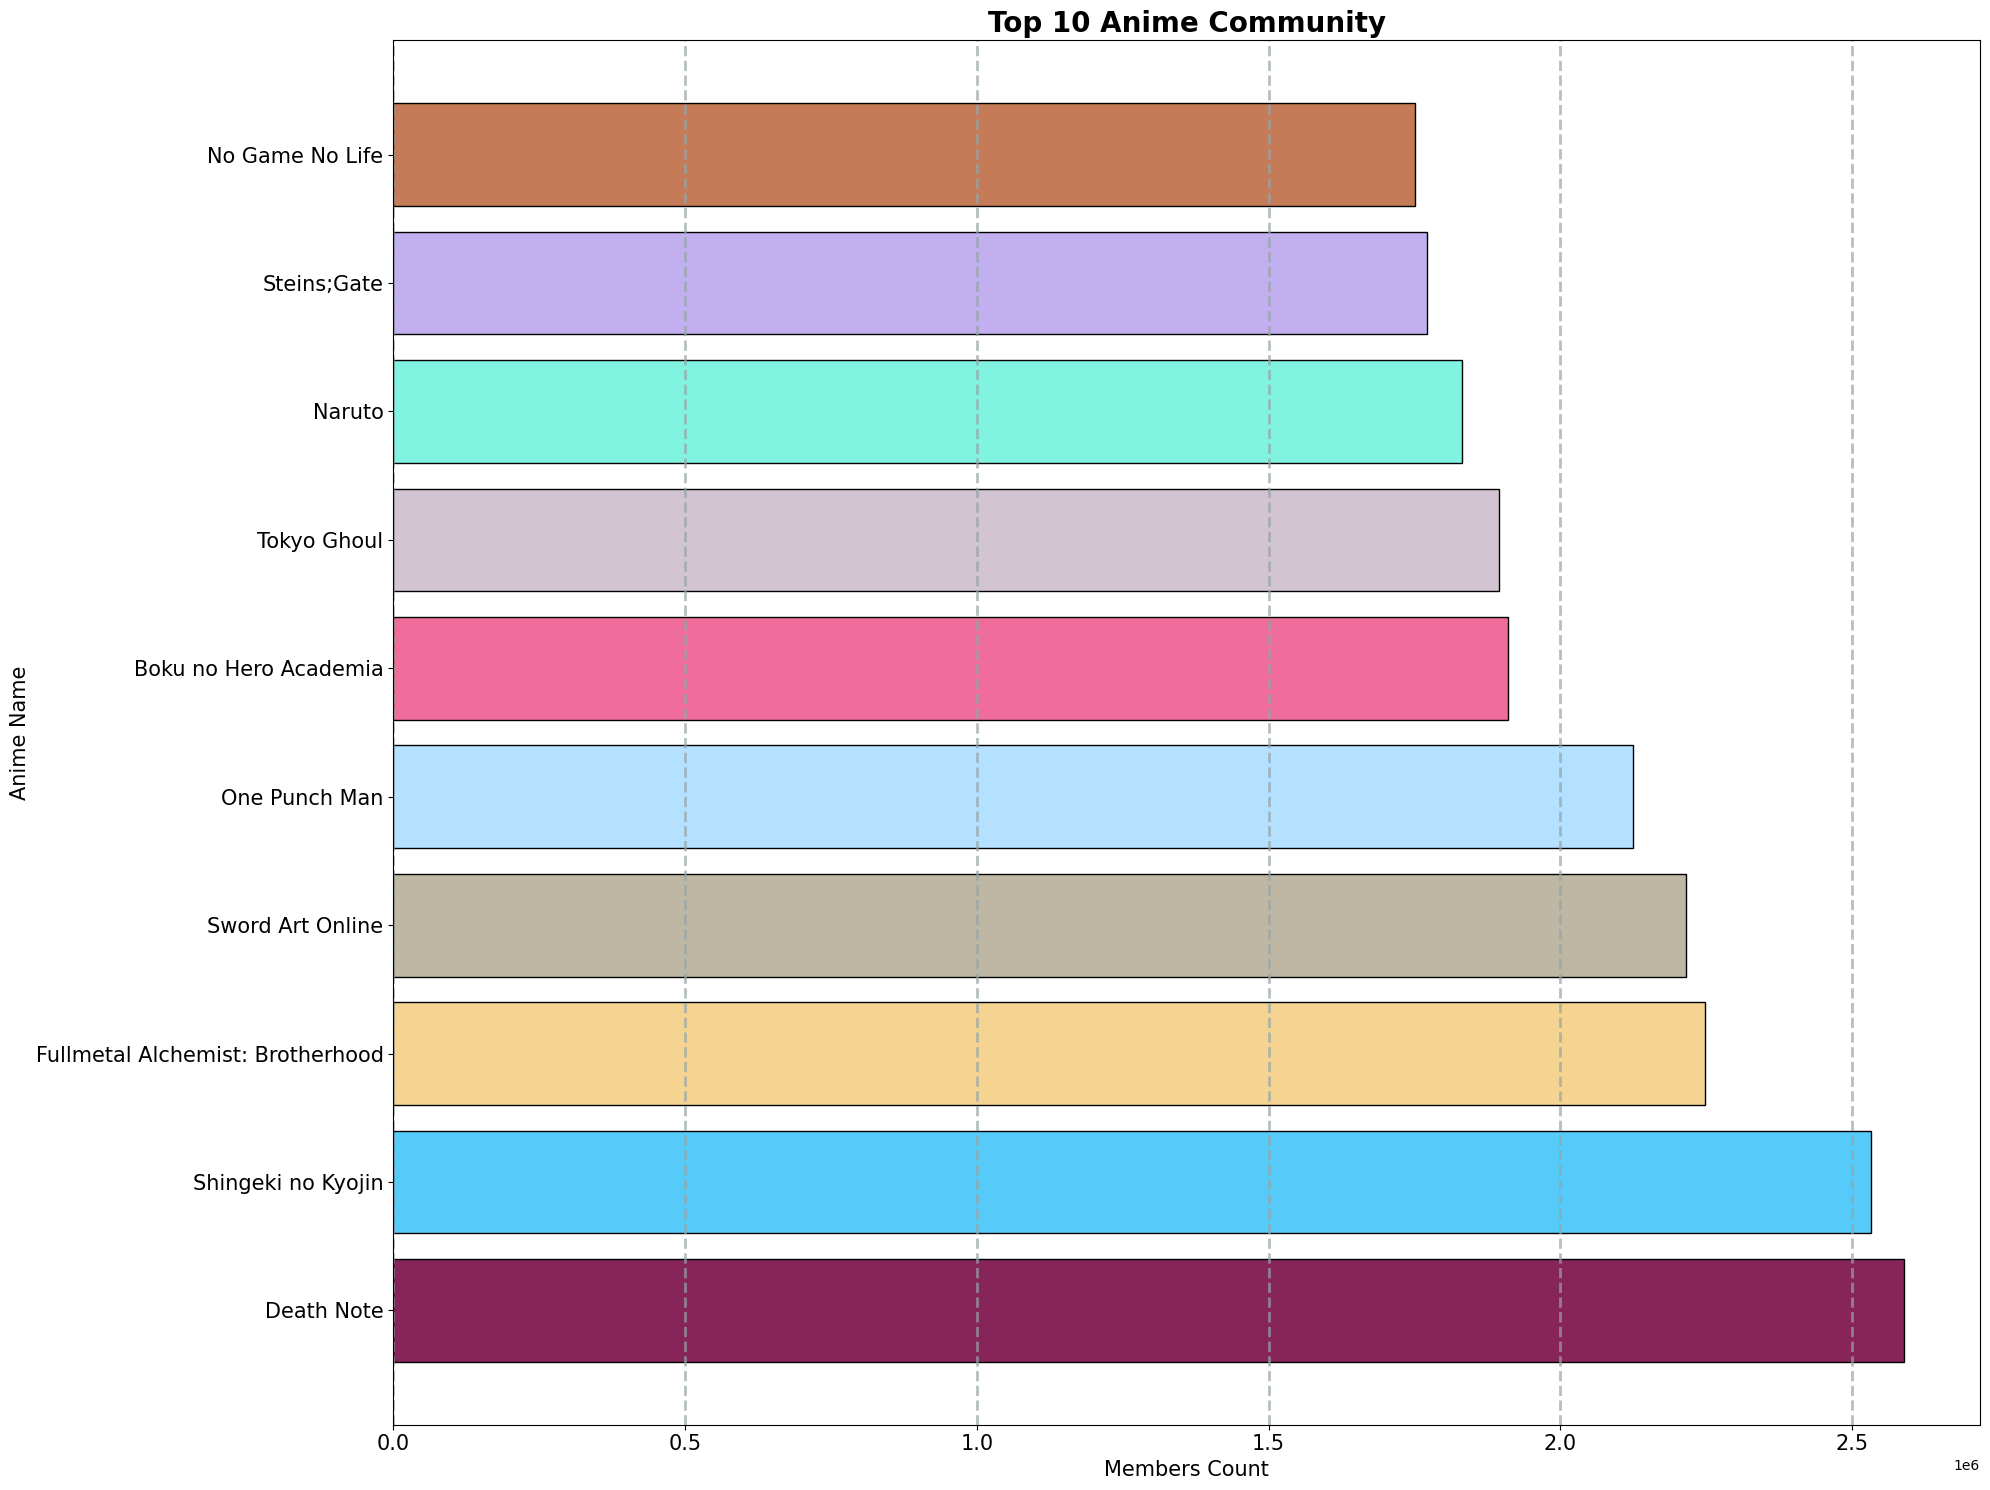

In [16]:
# Top 10 Anime based on Members
plt.figure(figsize=(20, 15))
top10_members = df[['Name', 'Members']].sort_values(by='Members', ascending=False).head(10)

colors_members = ['#87255B', '#56CBF9', '#F5D491', '#BEB7A4', '#B4E1FF', '#F06C9B',
                  '#D3C4D1', '#81F4E1', '#C2AFF0', '#C57B57']

labels_members = top10_members['Name'].values
values_members = top10_members['Members'].values

plt.barh(labels_members, values_members, color=colors_members, edgecolor='black')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='x', alpha=0.7)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Top 10 Anime Community", fontsize=20, fontweight='bold')
plt.xlabel('Members Count', fontsize=15)
plt.ylabel('Anime Name', fontsize=15)
plt.tight_layout()
plt.show()

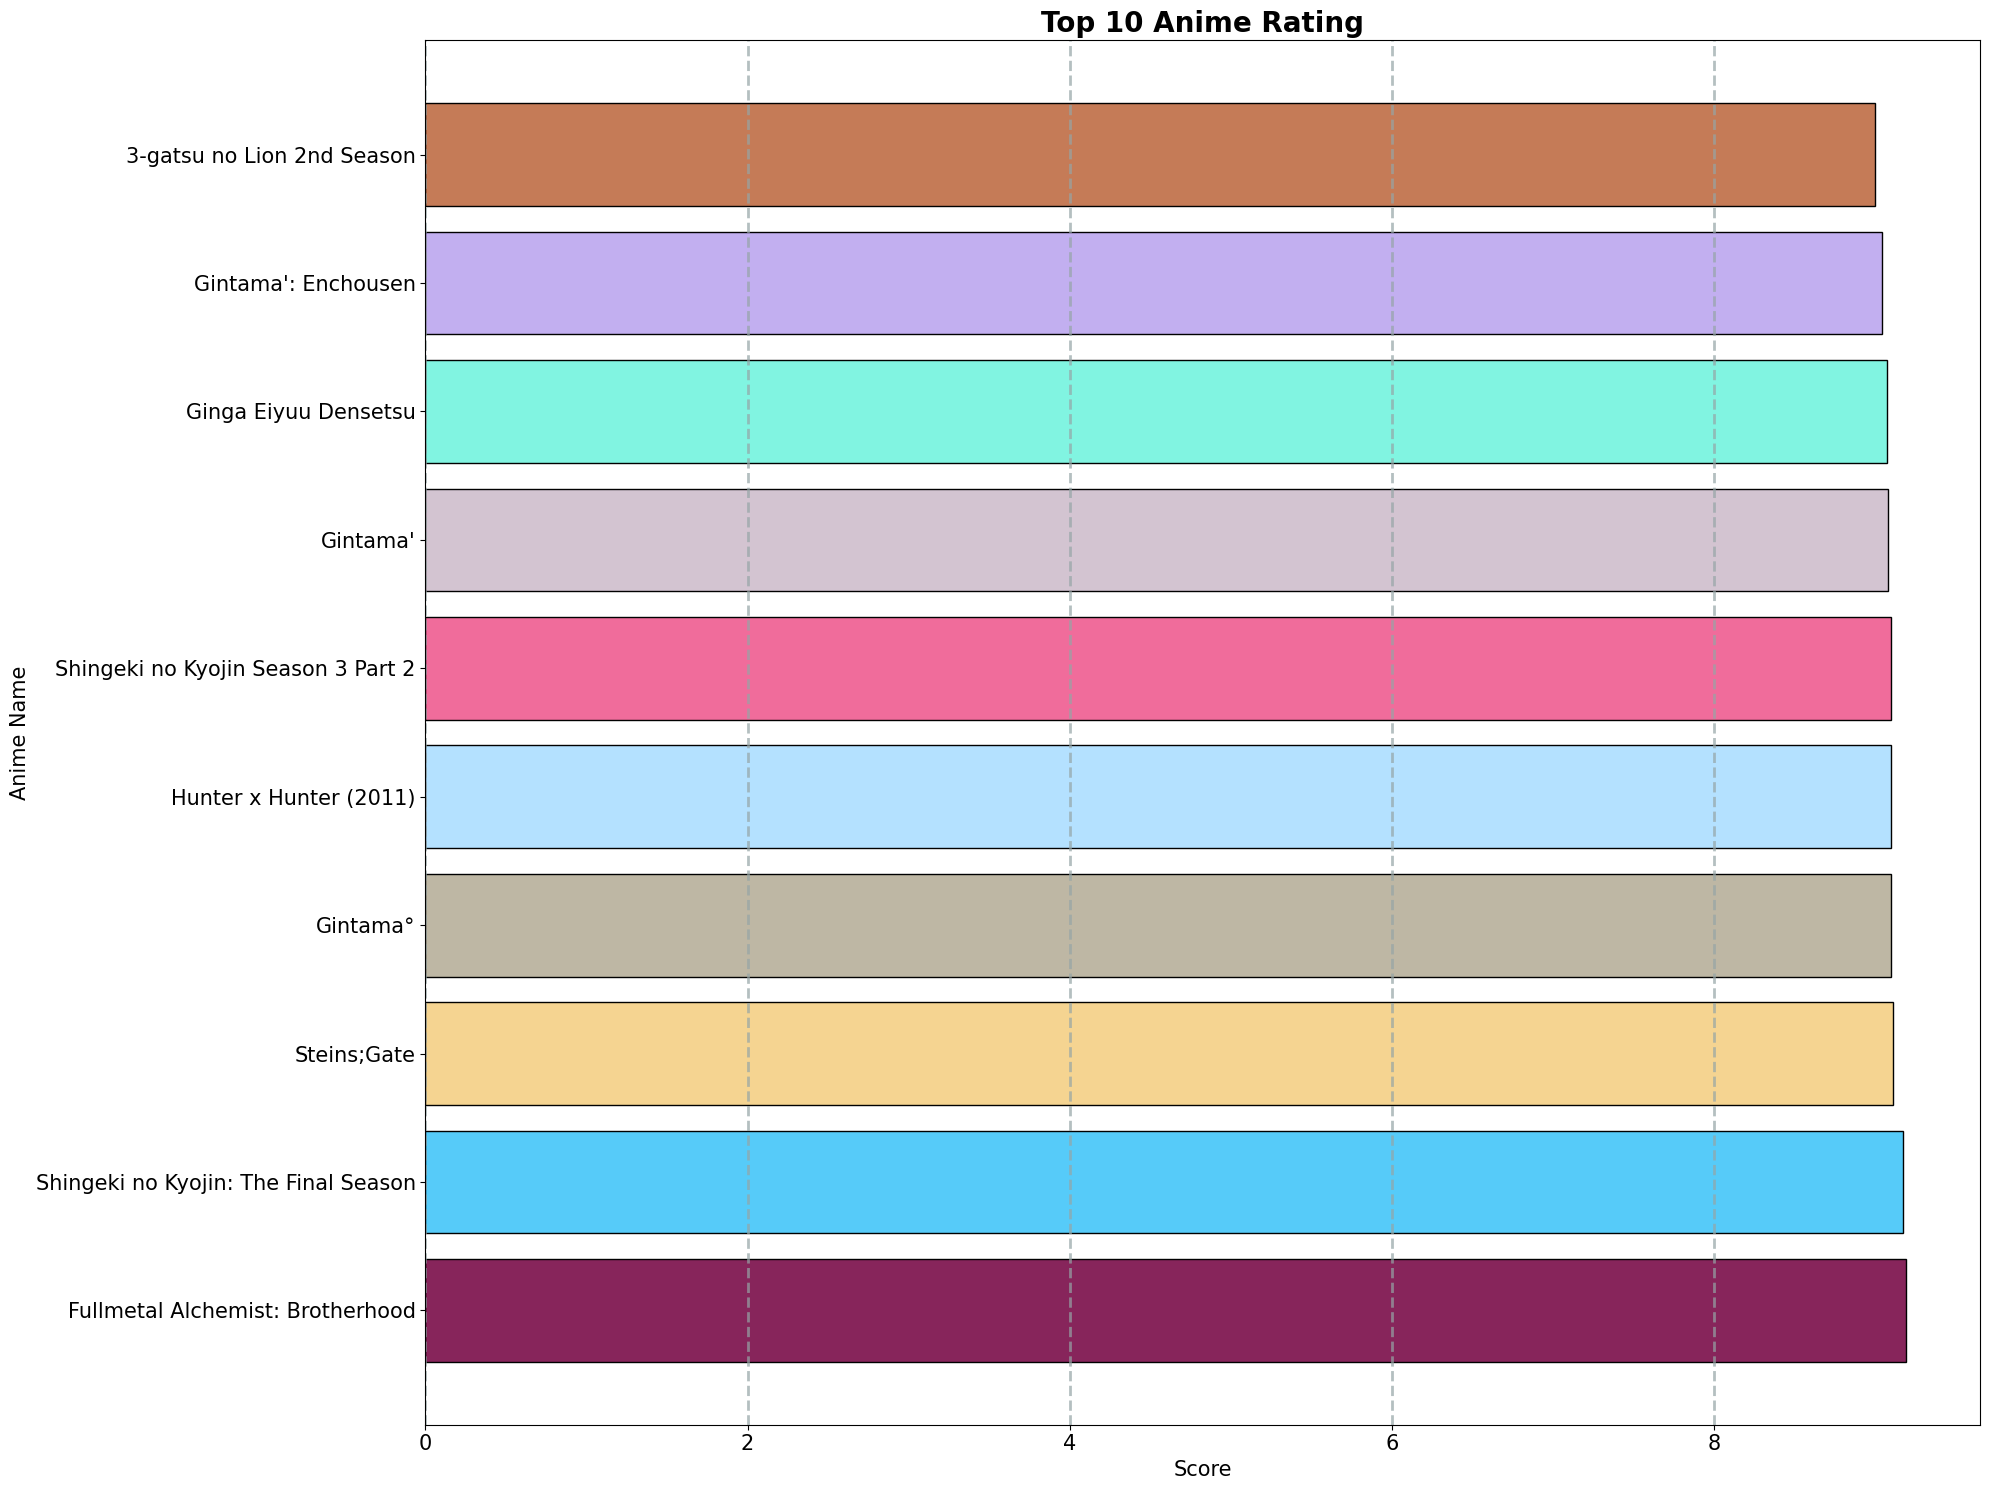

In [17]:
# Top 10 Anime berdasarkan Score
plt.figure(figsize=(20, 15))
top10_scores = df[['Name', 'Score']].sort_values(by='Score', ascending=False).head(10)

colors_scores = ['#87255B', '#56CBF9', '#F5D491', '#BEB7A4', '#B4E1FF', '#F06C9B',
                 '#D3C4D1', '#81F4E1', '#C2AFF0', '#C57B57']

labels_scores = top10_scores['Name'].values
values_scores = top10_scores['Score'].values

plt.barh(labels_scores, values_scores, color=colors_scores, edgecolor='black')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='x', alpha=0.7)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Top 10 Anime Rating", fontsize=20, fontweight='bold')
plt.xlabel('Score', fontsize=15)
plt.ylabel('Anime Name', fontsize=15)
plt.tight_layout()
plt.show()

## Data Preparation

In [18]:
import re

def text_cleaning(text):
  text = re.sub(r"[^\w\s]", "", text)
  text = re.sub(r"https?://[^\s]+", "", text)
  return text

df['Name'] = df['Name'].apply(text_cleaning)


Remove alphanumeric punctuation and Remove links (URLs)

In [19]:
df

,anime_id,Name,Score,Genres,English name,Japanese name,sypnopsis,Type,Episodes,Aired,...,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,"In the year 2071, humanity has colonized sever...",TV,26,"Apr 3, 1998 to Apr 24, 1999",...,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678
1,5,Cowboy Bebop Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,"other day, another bounty—such is the life of ...",Movie,1,"Sep 1, 2001",...,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,"Vash the Stampede is the man with a $$60,000,0...",TV,26,"Apr 1, 1998 to Sep 30, 1998",...,24 min. per ep.,PG-13 - Teens 13 or older,266.0,201,558913,12944,29113,343492,25465,13925
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),ches are individuals with special powers like ...,TV,26,"Jul 2, 2002 to Dec 24, 2002",...,25 min. per ep.,PG-13 - Teens 13 or older,2481.0,1467,94683,587,4300,46165,5121,5378
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,It is the dark century and the people are suff...,TV,52,"Sep 30, 2004 to Sep 29, 2005",...,23 min. per ep.,PG - Children,3710.0,4369,13224,18,642,7314,766,1108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14947,48481,Daomu Biji Zhi Qinling Shen Shu,6.51,"Adventure, Mystery, Supernatural",Unknown,盗墓笔记之秦岭神树,No synopsis information has been added to this...,ONA,Unknown,"Apr 4, 2021 to ?",...,Unknown,Unknown,NaN,13116,354,6,0,0,0,0
14948,48483,Mierukochan,6.51,"Comedy, Horror, Supernatural",Unknown,見える子ちゃん,ko is a typical high school student whose life...,TV,Unknown,2021 to ?,...,Unknown,Unknown,NaN,17562,7010,70,14,0,14,0
14949,48488,Higurashi no Naku Koro ni Sotsu,6.51,"Mystery, Dementia, Horror, Psychological, Supe...",Higurashi:When They Cry – SOTSU,ひぐらしのなく頃に卒,Sequel to Higurashi no Naku Koro ni Gou .,TV,Unknown,"Jul, 2021 to ?",...,Unknown,R - 17+ (violence & profanity),NaN,17558,11309,48,3,0,0,0
14950,48491,Yama no Susume Next Summit,6.51,"Adventure, Slice of Life, Comedy",Unknown,ヤマノススメ Next Summit,New Yama no Susume anime.,TV,Unknown,Unknown,...,Unknown,PG-13 - Teens 13 or older,NaN,17565,1386,2,13,2,2,1


In [20]:
df.duplicated().sum()

np.int64(0)

No duplicate data

In [21]:
df.isnull().sum()

,0
anime_id,0
Name,0
Score,0
Genres,0
English name,0
Japanese name,0
sypnopsis,1350
Type,0
Episodes,0
Aired,0


There are *Missing values* in the `sypnopsis and Ranked` columns

In [22]:
df = df.dropna()

Removing *Missing value* data

In [23]:
df.isnull().sum()

,0
anime_id,0
Name,0
Score,0
Genres,0
English name,0
Japanese name,0
sypnopsis,0
Type,0
Episodes,0
Aired,0


In [24]:
print(f'This dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

This dataset has 13229 rows and 25 columns.


The original number of datasets was `14952` and by removing the number of *missing values* the dataset is now `13229`.

In [25]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
anime_id,13229.0,18916.527478,14310.284710,1.00,4772.00,17113.00,33191.00,48456.00
Score,13229.0,6.549368,0.822849,1.85,6.12,6.51,7.08,9.19
Ranked,13229.0,6829.241364,4168.674693,1.00,3309.00,6614.00,9941.00,15780.00
Popularity,13229.0,7463.690906,4487.187134,1.00,3392.00,7517.00,11514.00,17500.00
Members,13229.0,45059.734523,142720.285794,200.00,641.00,3389.00,23222.00,2589552.00
Favorites,13229.0,601.686900,4672.643973,0.00,1.00,5.00,51.00,183914.00
Watching,13229.0,2908.379243,16125.259019,0.00,26.00,113.00,803.00,887333.00
Completed,13229.0,28973.528611,103921.255801,0.00,247.00,1561.00,12523.00,2182587.00
On-Hold,13229.0,1243.211505,4891.246416,0.00,14.00,71.00,459.00,187919.00
Dropped,13229.0,1534.773830,5412.823280,0.00,48.00,97.00,454.00,174710.00


The `describe()` function provides statistical information on each column, including:

- `Count` is the number of samples in the data.
- `Mean` is the average value.
- `Std` is the standard deviation.
- `Min` is the minimum value of each column.
- `25%` is the first quartile. Quartiles are values that mark the boundaries of intervals in four equal parts of the distribution.
- `50%` is the second quartile, also called the median. - 75%` is the third quartile.
- `Max` is the maximum value.

In [82]:
df

,anime_id,Name,Score,Genres,English name,Japanese name,sypnopsis,Type,Episodes,Aired,...,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,"In the year 2071, humanity has colonized sever...",TV,26,"Apr 3, 1998 to Apr 24, 1999",...,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678
1,5,Cowboy Bebop Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,"other day, another bounty—such is the life of ...",Movie,1,"Sep 1, 2001",...,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,"Vash the Stampede is the man with a $$60,000,0...",TV,26,"Apr 1, 1998 to Sep 30, 1998",...,24 min. per ep.,PG-13 - Teens 13 or older,266.0,201,558913,12944,29113,343492,25465,13925
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),ches are individuals with special powers like ...,TV,26,"Jul 2, 2002 to Dec 24, 2002",...,25 min. per ep.,PG-13 - Teens 13 or older,2481.0,1467,94683,587,4300,46165,5121,5378
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,It is the dark century and the people are suff...,TV,52,"Sep 30, 2004 to Sep 29, 2005",...,23 min. per ep.,PG - Children,3710.0,4369,13224,18,642,7314,766,1108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14916,47591,Kuro Gal ni Natta kara Shinyuu to shitemita,6.51,"Romance, Shounen Ai",Unknown,黒ギャルになったから親友としてみた。,Shion and Rui are the dream team when it comes...,TV,Unknown,"Feb 11, 2021 to ?",...,4 min.,R+ - Mild Nudity,15231.0,7387,3636,90,768,3,79,35
14917,47614,Nu Wushen de Canzhuo Spring Festival Special,6.83,"Slice of Life, Comedy",Cooking with Valkyries Spring Festival Special,Unknown,No synopsis information has been added to this...,Special,1,"Feb 11, 2021",...,10 min.,PG - Children,4382.0,11973,540,8,51,168,18,2
14918,47616,Yakusoku no Neverland 2nd Season Michishirube,4.81,"Mystery, Psychological, Supernatural, Thriller...",The Promised Neverland Season 2 Episode 5.5,約束のネバーランド 特別編「道標」,cap of the first season of Yakusoku no Neverla...,Special,1,"Feb 12, 2021",...,23 min.,R - 17+ (violence & profanity),10760.0,4398,13070,90,1183,8196,119,202
14924,47795,Ai Zai Xi Yuan Qian 2nd Season,6.51,"Fantasy, Romance",Immemorial Love For You 2nd Season,爱在西元前 第二季,No synopsis information has been added to this...,ONA,16,"Feb 14, 2021 to ?",...,Unknown,Unknown,13254.0,12411,463,35,40,0,7,7


In [146]:
data = df.drop(columns=['anime_id',
                        'Episodes',
                        'English name',
                        'Japanese name',
                        'sypnopsis',
                        'Episodes',
                        'Aired',
                        'Premiered',
                        'Producers',
                        'Licensors',
                        'Source',
                        'Duration',
                        'Rating',
                        'Ranked',
                        'Popularity',
                        'Members',
                        'Favorites',
                        'Watching',
                        'Completed',
                        'On-Hold',
                        'Dropped'])

Remove columns that are not needed in this model.

In [136]:
print("Number of duplicate anime names:", data['Name'].duplicated().sum())

Number of duplicate anime names: 46


In [137]:
# Create a ‘UniqueName’ field that will be the unique index
data['UniqueName'] = data['Name']

# Mark duplicate rows of names
dups = data['Name'].duplicated(keep=False)

# For duplicates, add a number suffix to make it unique
data.loc[dups, 'Name'] = data.loc[dups].groupby('Name').cumcount().astype(str) + '_' + data.loc[dups, 'Name']

In [113]:
data.head()

,Name,Score,Genres,Type,Studios,UniqueName
0,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,Sunrise,Cowboy Bebop
1,Cowboy Bebop Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Movie,Bones,Cowboy Bebop Tengoku no Tobira
2,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",TV,Madhouse,Trigun
3,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",TV,Sunrise,Witch Hunter Robin
4,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",TV,Toei Animation,Bouken Ou Beet


In [114]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13229 entries, 0 to 14943
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Name        13229 non-null  object 
 1   Score       13229 non-null  float64
 2   Genres      13229 non-null  object 
 3   Type        13229 non-null  object 
 4   Studios     13229 non-null  object 
 5   UniqueName  13229 non-null  object 
dtypes: float64(1), object(5)
memory usage: 1.2+ MB


### TF-IDF (Term Frequency-Inverse Document Frequency)

In [147]:
tfid = TfidfVectorizer()
tfid.fit(data['Genres'])

tfid.get_feature_names_out()

array(['action', 'adventure', 'ai', 'arts', 'cars', 'comedy', 'dementia',
       'demons', 'drama', 'ecchi', 'fantasy', 'fi', 'game', 'harem',
       'historical', 'horror', 'josei', 'kids', 'life', 'magic',
       'martial', 'mecha', 'military', 'music', 'mystery', 'of', 'parody',
       'police', 'power', 'psychological', 'romance', 'samurai', 'school',
       'sci', 'seinen', 'shoujo', 'shounen', 'slice', 'space', 'sports',
       'super', 'supernatural', 'thriller', 'unknown', 'vampire'],
      dtype=object)

The `fit_transform()` function computes the TF-IDF weights for each genre term within each document (movie).

In [148]:
tfidf_matrix = tfid.fit_transform(data['Genres'])


tfidf_matrix.shape

(13229, 45)

This means there are 13,229 movies and 45 unique genre features.

In [149]:
tfidf_matrix.todense()

matrix([[0.30417283, 0.34382085, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.29098327, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.33789893, 0.38194304, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.60096513, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

A sample snippet shows the TF-IDF weights for specific genres in each movie.

In [150]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfid.get_feature_names_out(),
    index=data.Genres
).sample(22, axis=1).sample(10, axis=0)

,thriller,adventure,game,dementia,shounen,arts,music,martial,harem,life,...,slice,fi,horror,power,romance,josei,mecha,unknown,drama,super
Genres,,,,,,,,,,,,,,,,,,,,,
"Action, Adventure, Fantasy",0.0,0.604093,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
"Comedy, Romance, School, Seinen, Slice of Life",0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.379490,...,0.379490,0.000000,0.0,0.000000,0.372531,0.0,0.0,0.0,0.0,0.000000
"Action, Fantasy",0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
"Action, Comedy, Military, Romance",0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.505329,0.0,0.0,0.0,0.0,0.000000
"Comedy, Fantasy, School",0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
"Action, Comedy, Demons, Ecchi, Harem, Romance, School",0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.502735,0.000000,...,0.000000,0.000000,0.0,0.000000,0.327784,0.0,0.0,0.0,0.0,0.000000
"Sci-Fi, Slice of Life",0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.467854,...,0.467854,0.414329,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
"Action, Military, Sci-Fi, Space",0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.360609,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
"Slice of Life, Comedy, Super Power, Seinen",0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.342330,...,0.342330,0.000000,0.0,0.460973,0.000000,0.0,0.0,0.0,0.0,0.460973


The above `tf-idf matrix` output shows the relationship between the anime name against the selected category. This matrix shows how much correlation between Anime and the selected category.

## Modelling

### Model Content Based Filtering

In [152]:
# Calculate cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix)

cosine_sim

array([[1.        , 0.78399904, 0.73975208, ..., 0.        , 0.        ,
        0.10622903],
       [0.78399904, 1.        , 0.51589414, ..., 0.20976923, 0.        ,
        0.        ],
       [0.73975208, 0.51589414, 1.        , ..., 0.12878306, 0.        ,
        0.1180075 ],
       ...,
       [0.        , 0.20976923, 0.12878306, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.10622903, 0.        , 0.1180075 , ..., 0.        , 0.        ,
        1.        ]])

In [153]:
# Create a cosine similarity dataframe with index and UniqueName column
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['UniqueName'], columns=data['UniqueName'])

print('Shape cosine_sim_df:', cosine_sim_df.shape)

Shape cosine_sim_df: (13229, 13229)


In [121]:
def anime_recommendations(anime_name, similarity_data=cosine_sim_df, items=data[['UniqueName','Genres']], k=5):


    index = similarity_data.loc[:,anime_name].to_numpy().argpartition(
        range(-1, -k, -1))


    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(anime_name, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

In [122]:
data[data.Name.eq('One Piece')]

,Name,Score,Genres,Type,Studios,UniqueName
11,One Piece,8.52,"Action, Adventure, Comedy, Super Power, Drama,...",TV,Toei Animation,One Piece


In [123]:
anime_recommendations('One Piece')

,UniqueName,Genres
0,One Piece Episode of Sorajima,"Action, Adventure, Comedy, Super Power, Drama,..."
1,One Piece Episode of Merry Mou Hitori no Naka...,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."
2,One Piece Movie 14 Stampede,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."
3,One Piece Episode of East Blue Luffy to 4nin ...,"Action, Adventure, Comedy, Super Power, Drama,..."
4,One Piece Episode of Sabo 3 Kyoudai no Kizuna...,"Action, Adventure, Comedy, Super Power, Drama,..."


The system has successfully recommended the top 5 percent of anime similar to *One Piece*, which are several movies and series from *One Piece* itself. So, if the user likes *One Piece*, then the system can recommend other *One Piece* series or movies.

### Model K-Nearest Neighbor

In [126]:
animedf_name = pd.DataFrame({'Name':data['UniqueName']})
animedf_name.head()

,Name
0,Cowboy Bebop
1,Cowboy Bebop Tengoku no Tobira
2,Trigun
3,Witch Hunter Robin
4,Bouken Ou Beet


In [127]:
data_indexed = data.set_index('UniqueName')
data_n = data_indexed[['Score','Type','Studios']]
data_dummies = pd.get_dummies(data_n[['Type','Studios']])
data_new = pd.concat([data_n, data_dummies], axis=1)
data_new = data_new.drop(columns=['Type', 'Studios'])

data_new.head()

,Score,Type_Movie,Type_Music,Type_ONA,Type_OVA,Type_Special,Type_TV,Studios_10Gauge,"Studios_10Gauge, Studio DURIAN",Studios_2:10 AM Animation,...,"Studios_feel., Zexcs","Studios_feel., Zexcs, Assez Finaud Fabric",Studios_helo.inc,Studios_iDRAGONS Creative Studio,"Studios_ixtl, LIDENFILMS",Studios_monofilmo,Studios_pH Studio,Studios_production doA,Studios_ufotable,"Studios_ufotable, feel., Studio Flag"
UniqueName,,,,,,,,,,,,,,,,,,,,,
Cowboy Bebop,8.78,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Cowboy Bebop Tengoku no Tobira,8.39,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Trigun,8.24,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Witch Hunter Robin,7.27,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Bouken Ou Beet,6.98,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [128]:
model = NearestNeighbors(metric='euclidean')
model.fit(data_new)

NearestNeighbors(metric='euclidean')

In [129]:
def Recommended_model(anime_name:str, recommend_anime:int=5):
  print(f'If the user likes app:{anime_name[0]} \nHere are apps that might also be liked:')
  distances, neighbors = model.kneighbors(data_new.loc[anime_name],n_neighbors=recommend_anime)
  similar_anime = []
  for anime_name in animedf_name.loc[neighbors[0][:]].values:
    similar_anime.append(anime_name[0])
  similar_distance = []
  for distance in distances[0]:
    similar_distance.append(f"{round(100-distance, 2)}%")
  return pd.DataFrame(data = {"Anime Name" : similar_anime, "Similiarity Score" : similar_distance})


In [130]:
Recommended_model(animedf_name.loc[21])

If the user likes app:Neon Genesis Evangelion Death  Rebirth 
Here are apps that might also be liked:


<ipython-input-129-1738761686>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'If the user likes app:{anime_name[0]} \nHere are apps that might also be liked:')


,Anime Name,Similiarity Score
0,Neon Genesis Evangelion Death Rebirth,100.0%
1,Neon Genesis Evangelion The End of Evangelion,98.94%
2,Kekkaishi TV,98.59%
3,Doraemon Doraemon Comes Back,98.59%
4,Dr Slump Aralechan,98.59%


## Evaluation

### Precision Score

---

**The Precision** is an evaluation metric used in classification tasks, particularly in scenarios where the focus is on the accuracy of positive predictions. It measures the proportion of true positive predictions out of all instances that the model predicted as positive. Precision is especially important in cases where false positives are costly or undesirable, such as medical diagnosis or spam detection.

**The Precision** formula is:


$${Precision} = \frac{TP}{TP + FP}$$


Where:
- \( TP \) (True Positives) adalah jumlah data yang benar-benar positif dan diprediksi positif oleh model.
- \( FP \) (False Positives) adalah jumlah data yang sebenarnya negatif tetapi diprediksi positif oleh model.

Precision values range between 0 and 1. The higher the Precision value, the better the model is at accurately predicting positives without generating many false positives.

---

In [154]:
def is_relevant(genres1, genres2):
    set1 = set(genres1.split(', '))
    set2 = set(genres2.split(', '))
    return len(set1.intersection(set2)) > 0

k = 5
precision_scores = []

for anime_id in data['UniqueName']:
    sim_scores = cosine_sim_df.loc[anime_id].drop(anime_id)
    top_k_anime = sim_scores.sort_values(ascending=False).head(k).index

    target_genre = data.loc[data['UniqueName'] == anime_id, 'Genres'].values[0]

    relevant_count = 0
    for rec_id in top_k_anime:
        rec_genre = data.loc[data['UniqueName'] == rec_id, 'Genres'].values[0]
        if is_relevant(target_genre, rec_genre):
            relevant_count += 1

    precision = relevant_count / k
    precision_scores.append(precision)

mean_precision = np.mean(precision_scores)
print(f'Average Precision@{k}: {mean_precision:.4f}')

Average Precision@5: 1.0000


The Precision@5 value of 1.0 indicates that all the top 5 recommendations for each anime are truly relevant based on the genre overlap criteria.

This indicates that the genre-based cosine similarity model successfully recommends anime that are very similar in genre, so the model is very effective in the context of the data and relevance definition used.

### Calinski-Harabasz score

_**The Calinski-Harabasz score**_ is an evaluation metric for clustering algorithms that measures how well the clustering separates the data into compact, discrete groups. Defined as the ratio between the scatter within clusters and the scatter between clusters, the higher the CH value, the better the clustering performance, without requiring information about the ground truth labels.

**The Calinski-Harabasz Score** (CH) formula is:
$$CH = \frac{B}{W} \times \frac{N - k}{k - 1}$$

Where:
- \( B \) is the between-cluster scatter.
- \( W \) is the within-cluster scatter.
- \( N \) is the total amount of data.
- \( k \) is the number of clusters.

In [131]:
ch_score = calinski_harabasz_score(data_new, animedf_name)

In [132]:
ch_score

np.float64(3.1613291729405617)

The evaluation results show that the clusters in this model are still not well separated, which is reflected in the relatively low Calinski-Harabasz (CH) score of `3.1613291729405617`. This indicates the potential for inappropriate recommendations in some applications, which may not fully match user preferences. Therefore, further review or adjustments to the model are needed to improve cluster separation and recommendation accuracy.

### Davies Bouldin Score

 _**Davies Bouldin Score (DB)**_ is a clustering performance evaluation metric that measures the average similarity of each cluster to its most similar cluster by comparing the distance within the cluster to the distance between clusters. With a minimum score of zero, the lower the DB value, the better the clustering performance, indicating clusters that are closer to each other and less dispersed. Different from most metrics, DB does not require a priori knowledge of ground truth labels, similar to Silhouette Score, but has a simpler formulation, providing an efficient way to evaluate clustering without requiring additional knowledge of the data structure.

The Davies-Bouldin Score (DB) formula is:


$$ DB = \frac{1}{k}\sum_{i=1}^{k}\max_{j\neq i}\left( \frac{R_i + R_j}{d(c_i, c_j)}\right) $$


Where:
- \( k \) is the number of clusters.
- \( R_i \) is the radius in the i-th cluster.
- \( d(c_i, c_j) \) is the distance between the i-th cluster center (\( c_i \)) and the j-th cluster center (\( c_j \)).

Davies-Bouldin is defined as the average of the R values, where each R value is the ratio between the sum of the radius within the cluster (in terms of distance, e.g. Euclidean distance) and the distance between the cluster centers, and the other centers. This ratio is used to evaluate the similarity of each cluster with other clusters.

In [133]:
db_score = davies_bouldin_score(data_new, animedf_name)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [49]:
db_score

np.float64(0.7864266764751376)

The Davies-Bouldin (DB) evaluation results show that the model has a relatively small score, with a DB value of `0.7864266764751376` This indicates that the model already has a fairly good cluster separation. As a result, the anime recommendations are of good quality, considering that the cluster grouping in the model is already quite effective in separating the data. This is proven by the results of the application recommendations that are already quite good.